# **Audio Classification**

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display
from google.colab import files
uploaded = files.upload()

%matplotlib inline

Saving audio_test.csv to audio_test.csv
Saving audio_train.csv to audio_train.csv


In [3]:
x_train = pd.read_csv('audio_train.csv')
x_test = pd.read_csv('audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(7837, 10)


In [4]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(7837, 10) (1960, 10)
{2: 2350, 5: 1343, 1: 1336, 3: 993, 4: 936, 0: 879}


In [5]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [6]:
features = ['sig_mean', 'sig_std', 'rmse_mean', 'rmse_std', 'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std']

x_train_features = x_train[features]
x_test_features = x_test[features]

Test Set Accuracy =  0.569
Test Set F-score =  0.563
Test Set Precision =  0.580
Test Set Recall =  0.573
Confusion matrix, without normalization
[[ 73  41  87   2   5  16]
 [ 36  47 163   2   3  49]
 [ 22  58 424   1  14  64]
 [  0   0   0 247   0   0]
 [  0   0   0   0 241   0]
 [ 16  31 223   0  12  83]]


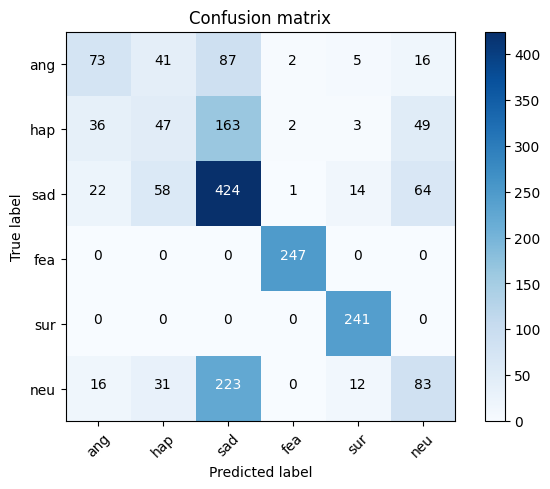

In [8]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Set Accuracy =  0.323
Test Set F-score =  0.150
Test Set Precision =  0.191
Test Set Recall =  0.212
Confusion matrix, without normalization
[[ 58  15 151   0   0   0]
 [ 17  15 268   0   0   0]
 [ 12  11 560   0   0   0]
 [  0   0 247   0   0   0]
 [ 23   1 217   0   0   0]
 [  6   3 356   0   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


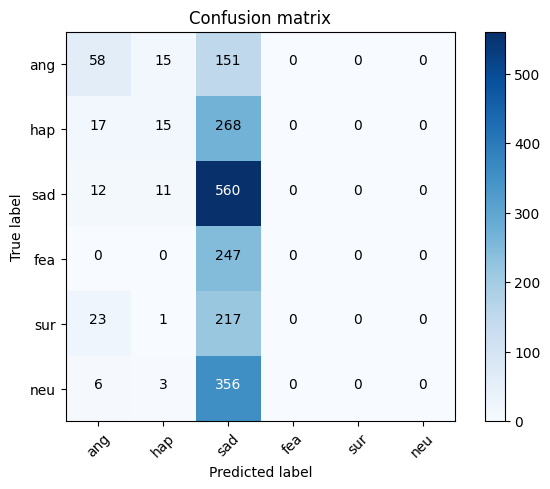

In [10]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)


**CNN**

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Ensure x_train_features, x_test_features, y_train, y_test, and emotion_dict are defined
# Example dummy definitions (replace these with your actual data):
# x_train_features, x_test_features = np.random.rand(100, 50), np.random.rand(20, 50)
# y_train, y_test = np.random.randint(0, 5, 100), np.random.randint(0, 5, 20)
# emotion_dict = {0: "Happy", 1: "Sad", 2: "Angry", 3: "Neutral", 4: "Surprised"}

# Define the CNN model
model = models.Sequential()
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(x_train_features.shape[1], 1)))
model.add(layers.MaxPooling1D(pool_size=1))
model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=1))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(emotion_dict), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape data for Conv1D
x_train_cnn = np.array(x_train_features).reshape(-1, x_train_features.shape[1], 1)
x_test_cnn = np.array(x_test_features).reshape(-1, x_test_features.shape[1], 1)

# Train the CNN
history = model.fit(x_train_cnn, y_train, epochs=200, batch_size=20, validation_data=(x_test_cnn, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test_cnn, y_test)
print(f'Test Accuracy: {test_acc:.3f}')


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


392/392 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2999 - loss: 1.7220 - val_accuracy: 0.3276 - val_loss: 1.6541
Epoch 2/200
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3317 - loss: 1.6463 - val_accuracy: 0.3245 - val_loss: 1.6340
Epoch 3/200
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3246 - loss: 1.6408 - val_accuracy: 0.3286 - val_loss: 1.6353
Epoch 4/200
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3240 - loss: 1.6274 - val_accuracy: 0.3321 - val_loss: 1.6245
Epoch 5/200
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3226 - loss: 1.6299 - val_accuracy: 0.3286 - val_loss: 1.6158
Epoch 6/200
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3297 - loss: 1.6150 - val_accuracy: 0.3332 - val_loss: 1.6112
Epoch 7/200
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3248 - loss: 1.6161 - val_accuracy: 0.3383 - val_loss: 1.6041
Epoch 8/200
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3326 - loss: 1.6091 - val_accuracy: 0.3327